# <center> SARIMA Model to forecast Earnings <center>


In [1]:
from statsmodels.graphics.tsaplots import *
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')

from pylab import rcParams
rcParams['figure.figsize'] = 16, 8

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from google.colab import files
uploaded = files.upload()

Saving jj.csv to jj.csv


In [4]:
data = pd.read_csv('jj.csv')
data.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


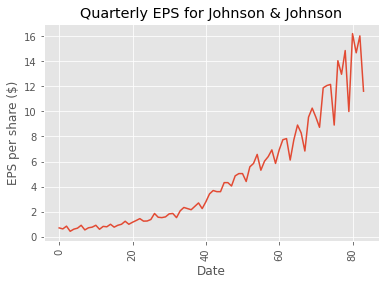

In [8]:
plt.plot(data['data'])
plt.title('Quarterly EPS for Johnson & Johnson')
plt.ylabel('EPS per share ($)')
plt.xlabel('Date')
plt.xticks(rotation = 90)
plt.show()

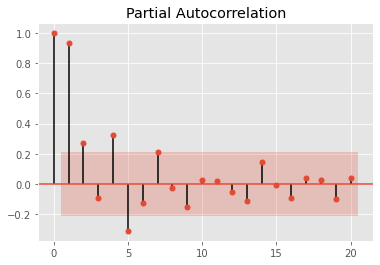

In [9]:
plot_pacf(data['data']);

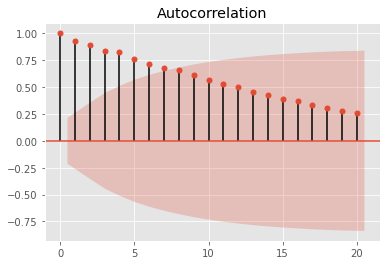

In [10]:
plot_acf(data['data']);

In [11]:
ad_fuller_result = adfuller(data['data'])
print(f'ADF Statistic : {ad_fuller_result[0]}')
print(f'p-value : {ad_fuller_result[1]}')

ADF Statistic : 2.742016573457474
p-value : 1.0


In [12]:
data['data'] = np.log(data['data'])
data['data'] = data['data'].diff()
data = data.drop(data.index[0])

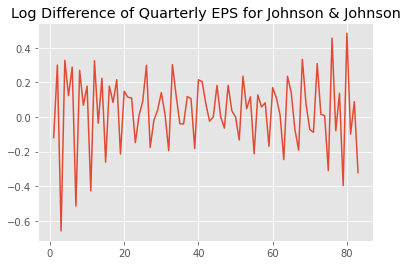

In [13]:
plt.plot(data['data'])
plt.title("Log Difference of Quarterly EPS for Johnson & Johnson")
plt.show()

In [32]:
data['data'] = data['data'].diff(4)
data = data.drop([1, 2, 3, 4], axis = 0).reset_index(drop = True)

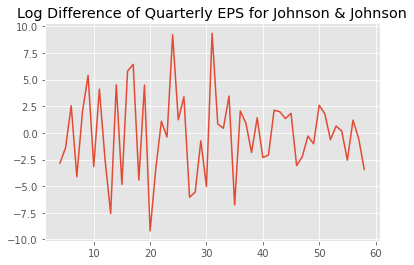

In [33]:
plt.plot(data['data'])
plt.title("Log Difference of Quarterly EPS for Johnson & Johnson")
plt.show()

In [36]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    results = []
    for param in tqdm_notebook(parameters_list):
        try : 
            model = SARIMAX(exog, order = (param[0], d, param[1]), seasonal_order = (param[2], D, param[3], s)).fit(disp = -1)
        except :
            continue
        aic = model.aic
        results.append([param, aic])
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    result_df = result_df.sort_values(by = 'AIC', ascending = True).reset_index(drop = True)
    return result_df

In [38]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 4
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

256


In [39]:
result_df = optimize_SARIMA(parameters_list, 1, 1, 4, data['data'])
result_df

,"(p,q)x(P,Q)",AIC
0,"(2, 3, 3, 2)",232.653408
1,"(3, 2, 2, 3)",234.572912
2,"(2, 2, 2, 3)",234.691609
3,"(2, 3, 2, 2)",235.059605
4,"(3, 3, 3, 2)",236.179659
...,...,...
247,"(0, 2, 0, 0)",414.484576
248,"(3, 0, 0, 0)",420.917995
249,"(2, 0, 0, 0)",425.889593
250,"(1, 0, 0, 0)",430.469253


In [40]:
best_model = SARIMAX(data['data'], order = (0, 1, 2), seasonal_order = (0, 1, 2, 4)).fit(dis = -1)
print(best_model.summary())

                                 Statespace Model Results                                
Dep. Variable:                              data   No. Observations:                   59
Model:             SARIMAX(0, 1, 2)x(0, 1, 2, 4)   Log Likelihood                -156.779
Date:                           Sun, 22 Nov 2020   AIC                            323.559
Time:                                   13:02:13   BIC                            333.503
Sample:                                        0   HQIC                           327.394
                                            - 59                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.2616     66.975     -0.019      0.985    -132.530     130.007
ma.L2          0.2620     17.444      0.015

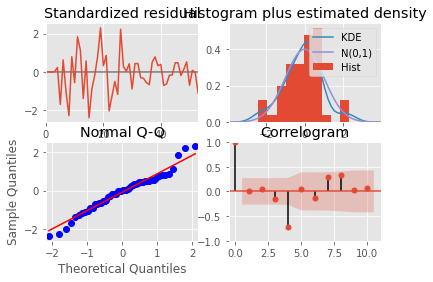

In [41]:
best_model.plot_diagnostics();

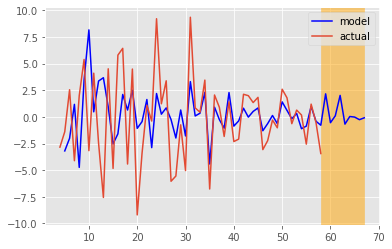

In [44]:
data['arima_model'] = best_model.fittedvalues
data['arima_model'][:4+1] = np.NaN
forecast = best_model.predict(start = data.shape[0], end = data.shape[0] + 8)
forecast = data['arima_model'].append(forecast)
plt.plot(forecast, color = 'b', label = 'model')
plt.axvspan(data.index[-1], forecast.index[-1], alpha = 0.5, color = 'orange')
plt.plot(data['data'], label = 'actual')
plt.legend()
plt.show()